# A one-factor affine term structure model
## When $\lambda=0$, the model is Vasicek
$dr(t)=\{\mu-\kappa r(t)\}dt+\sqrt{\sigma} dW(t)$

In [1]:
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
token = pd.read_csv("TOKEN.txt").columns[0]
n = range(1,21)
nms = ["CHRIS/CME_ED"+str(i) for i in n]
dfs = [quandl.get(nm, authtoken=token,start_date="2016-01-01", end_date="2017-12-30") for nm in nms]
#construct settle price
settle=dfs[0].Settle
for i in range(1,20):
    settle=pd.concat([settle,dfs[i].Settle],axis=1)
settle.columns=["Settle_ED"+str(i+1) for i in range(20)]
settle=settle.ffill()
settle.head()

,Settle_ED1,Settle_ED2,Settle_ED3,Settle_ED4,Settle_ED5,Settle_ED6,Settle_ED7,Settle_ED8,Settle_ED9,Settle_ED10,Settle_ED11,Settle_ED12,Settle_ED13,Settle_ED14,Settle_ED15,Settle_ED16,Settle_ED17,Settle_ED18,Settle_ED19,Settle_ED20
Date,,,,,,,,,,,,,,,,,,,,
2016-01-04,99.275,99.115,98.955,98.790,98.645,98.500,98.375,98.26,98.170,98.085,98.010,97.930,97.870,97.805,97.745,97.685,97.635,97.580,97.530,97.475
2016-01-05,99.285,99.130,98.970,98.810,98.665,98.525,98.405,98.29,98.200,98.115,98.040,97.960,97.900,97.835,97.775,97.710,97.660,97.605,97.550,97.490
2016-01-06,99.300,99.160,99.020,98.870,98.735,98.600,98.480,98.37,98.290,98.210,98.135,98.060,98.000,97.935,97.875,97.810,97.755,97.700,97.645,97.585
2016-01-07,99.315,99.195,99.065,98.925,98.795,98.665,98.550,98.44,98.355,98.270,98.195,98.115,98.050,97.985,97.920,97.850,97.795,97.735,97.675,97.615
2016-01-08,99.300,99.185,99.070,98.940,98.825,98.710,98.605,98.50,98.420,98.340,98.265,98.180,98.115,98.050,97.985,97.915,97.860,97.800,97.740,97.675


### Fit the model with initialized value

In [6]:
#1F Short Rate Model:
#dr(t)={mu-kappa*r(t)}*dt+vol*dW(t)
# pt=exp(A-Br)
class Model:
    def __init__(self,r0,mu,vol,kappa):
        self.r0 = r0
        self.mu = mu
        self.vol = vol
        self.var = vol*vol
        self.kappa=kappa
        
    def mean_r(self,t,dist='Q'): 
        m = np.exp(-self.kappa*t)*(self.r0+self.mu/self.kappa*(np.exp(kappa*t)-1))
        #if (dist == 'F'):m -= self.var * pow(t,2)
        return m
    
    def A(self,tau):
        return (self.mu/self.kappa-self.var/(2*self.kappa**2))*(self.B(tau)-tau)-self.var*self.B(tau)**2/(4*kappa)

    def B(self,tau):
        return (1-np.e**(-self.kappa*tau))/self.kappa

    def zero(self,t0,T,r_t0):
        tau = T-t0
        return np.exp(self.A(tau)-self.B(tau)*r_t0)
    
    def mean_rate(self,t_fix,T0,T1,dist='Q',accrual=0.25):
        A_diff = self.A(T0-t_fix) - self.A(T1-t_fix)
        B_diff = self.B(T0-t_fix) - self.B(T1-t_fix)
        m = A_diff - B_diff * self.mean_r(t_fix,dist)
        v = self.var *(1-np.exp(-2*self.kappa*t_fix))/(2*self.kappa) * pow(B_diff,2)
        e = np.exp(m+v/2.)
        return 1/accrual * (e-1),A_diff,B_diff
    
    def update_params(self,x):
        self.r0=x[0]
        self.mu=x[1]
        self.vol=x[2]
        self.var = pow(x[2],2)
        self.kappa=x[3]


In [7]:
#test Model class:
r0 = 0.015
mu = 0.005
vol = np.sqrt(0.008)
kappa=0.1
m = Model(r0,mu,vol,kappa)
m.mean_rate(0,0,1)

(0.062301233420138935, 0.0011808708862671366, -0.9516258196404048)

In [37]:
#test Model class:
r0 = 0.015
mu = 0.005
vol = np.sqrt(0.008)
kappa=0.1
m = Model(r0,mu,vol,kappa)

print ("The zero coupon bond price for the parameters is: ",m.zero(0,1,r0))

x = range(1,21)
term = [xx/4. for xx in x]
rate_Q = [m.mean_rate(t,t,t+0.25,'Q')*100 for t in term]

The zero coupon bond price for the parameters is:  0.9846635614051481


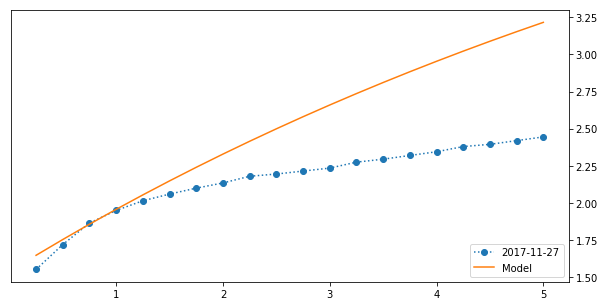

In [38]:
def plot_futures(dt,frame,x,y):
    f = plt.figure(figsize=(10,5))
    ax = f.add_subplot(111)
    ax.yaxis.tick_right()  
    crv = frame.loc[dt]
    crv_rates = [100-z for z in crv.values]
    plots = [plt.plot(x,crv_rates,label=dt,linestyle="dotted",marker='o'),plt.plot(x,y,label='Model')]
    plt.legend(loc='lower right')    
    plt.show()
    
dt = '2017-11-27'
plot_futures(dt,settle,term,rate_Q)
#plot_futures(dt,df,term,rate_F)


### Optimization Process

In [39]:
from scipy.optimize import least_squares, leastsq

class Fitter:
    def __init__(self,model,fut_data,terms,dist):
        self.model = model
        self.data = np.array(fut_data)
        self.terms = terms
        self.dist = dist
    
    def residuals(self,x):
        m = self.model
        m.update_params(x)
        rate_dist = [m.mean_rate(t,t,t+0.25,self.dist)*100 for t in self.terms]
        return np.array(rate_dist) - self.data
    
    def fit(self,x0,solver='lm'):
        return least_squares(self.residuals,x0,method=solver)
        #return leastsq(self.residuals,x0)

In [40]:
crv =settle.loc[dt]
crv_rates = [100-z for z in crv.values]
#print(crv_rates)
f_fut = Fitter(m,crv_rates,term,'Q')

In [41]:
fut = f_fut.fit([0.005,0.015,0.008,0.1])
print (fut.x)
#jacobian:
jac = fut.jac

[-0.00639492 -0.01235264  0.22327402  0.57738818]


In [42]:
#[r0,mu,vol,kappa]=fut.x
#m1= Model(r0,mu,vol,kappa)

x = range(1,21)
term = [xx/4. for xx in x]

#rate_F = [m.mean_rate(t,t,t+0.25,'F')*100 for t in term]
rate_Q = [m.mean_rate(t,t,t+0.25,'Q')*100 for t in term]


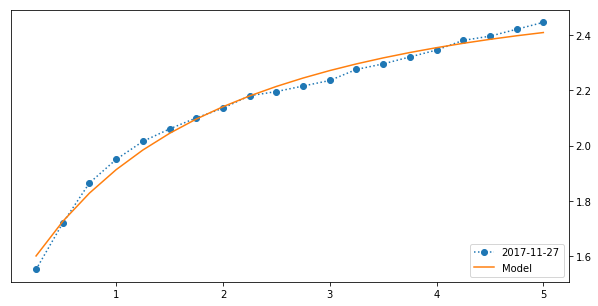

In [43]:
plot_futures(dt,settle,term,rate_Q)

In [44]:
c = np.cov(np.transpose(jac))
val, vec = np.linalg.eig(c)
#Condition number:
cn = val[0]/val[2]
print (cn)

170253.03361299148


After iteration using the package least_squares from scipy.optimize, after optimization, the last Jacobian matrix have serious collinearity problems according to the large Conditional Number, which would cause the problem of inversing the approximate Hessian matrix. In next part of the question we would use PCA rank reduction in every iteration in the Jacobian matrix to make it easy to be inversed.

## When $\lambda \neq 0$ , reason the case:

When $\lambda \neq 0$, the model becomes $dr(t)=\{\mu-\kappa r(t)\}dt+\sqrt{\gamma r(t)+\sigma} dW(t)$, the diffusion parameters for the process become related to the r(t) itself, which makes it not a gaussian process anymore. It's like a CIR model, the diffusion term become stochastic as well. 

Unlike the interest rate in the Hull-White model, the interest rate in the this model when $ \lambda \neq 0$ can be very hard to take negative values. When the interest rate approaches zero, the term $\sqrt{\gamma r(t)+\sigma} dW(u)$ also approaches zero. With the volatility disappearing, the behavior of the interest rate near zero depends on the drift term $\{\mu-\kappa r(t)\}dt$ , and this is a > 0 when R(u) is nearly 0. The positive drift prevents the interest rate from crossing zero into negative territory.

The close form of the model when  $\lambda \neq 0$ becomes very hard to calculate, although they no more have a simple close form like the Vasicek model we discussed above, we need to use moment-generating function to calculate the first and second  moments aka their means and variance for the model. They are still mean-reverting as before, but due to their unstable diffusion terms there are many ways to relieve the issue. Time varying functions replacing coefficients can be introduced in the model in order to make it consistent with a pre-assigned term structure of interest rates and possibly volatilities. The most general approach is in Maghsoodi (1996). A more tractable approach is in Brigo and Mercurio (2001b) where an external time-dependent shift is added to the model for consistency with an input term structure of rates.

##  If it is 2-factor model:

In the two-factor model of this subsection, both factors are highly likely to be nonnegative at all times almost surely. We again define the interest rate by but now assume that 

$$r(t)=\lambda_0 + \lambda_1 Y_1(t) +\lambda_2 Y_2(t)$$

where $Y_i(t)$ are the canonical factors for the two factor model.The evolution of the factor processes in the canonical two-factor model is given by:

$$dY_1(t)=\{\mu_1-\kappa_1 r_1(t)\}dt+\sqrt{\gamma_1 Y_1(t)+\sigma_1} dW_1(t)$$
$$dY_2(t)=\{\mu_2-\kappa_2 r_2(t)\}dt+\sqrt{\gamma_2 Y_2(t)+\sigma_2} dW_2(t)$$

when i=2, the two factor would have effect on the r(t) together, and the effect would be more complex and it would be very hard to get the distribution of the two-factor model. The rates would be still hard to be negative. But the mean-reverting process property would hold as well. The Brownian motions W1 (t) and W2(t) above are assumed to be independent. We do not need this assumption to guarantee nonnegativity of Y1 (t) and Y2(t) but rather to obtain the affine-yield result below.

# Problem 2

In [47]:
import QuantLib as ql
imm = ql.IMM()

d1 = ql.Date(27,11,2017)
M_dates=[d1]
terms=[]
for i in range(20):
    dn = imm.nextDate(M_dates[-1])
    terms.append(dn-M_dates[-1])
    M_dates.append(dn)
terms_new=np.array(np.cumsum(terms))/365  

I need to use it to determine the accurate maturity date in the model. Because in last question we olny use the list of [0.25 0.5 0.75....] as our maturity length. Professor in the class could use this is simplly because the first day is just a maturity date so the gap between the first day and second maturity date is 0.25 of the year which is 3 month. But in this case, the terms become something new because the first day is "11/27/2017", so the gap is no longer the 3 month. 

To make the result accurate, we need to recalibrate the gaps between term in the problems and recalculate the term structure in the TSM model. The new terms I calculated is below:

In [48]:
terms_new

array([0.0630137 , 0.31232877, 0.56164384, 0.8109589 , 1.06027397,
       1.30958904, 1.55890411, 1.80821918, 2.05753425, 2.30684932,
       2.55616438, 2.80547945, 3.05479452, 3.30410959, 3.55342466,
       3.80273973, 4.05205479, 4.30136986, 4.55068493, 4.81917808])

## The Model A: TSM

Use the new terms to recalculate it:

In [53]:
#test Model class:
r0 = 0.015
mu = 0.005
vol = np.sqrt(0.008)
kappa=0.1
m = Model(r0,mu,vol,kappa)

x = range(1,21)
term = [xx/4. for xx in x]
#rate_F = [m.mean_rate(t,t,t+0.25,'F')*100 for t in term]
#rate_Q = [m.mean_rate(t,t,t+0.25,'Q')*100 for t in term]
rate_Q = [m.mean_rate(terms_new[t],terms_new[t],terms_new[t]+0.25,'Q')*100 for t in range(20)]


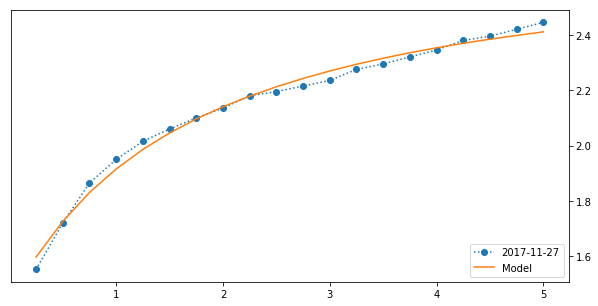

In [58]:
   
dt = '2017-11-27'
plot_futures(dt,settle,term,rate_Q)
#plot_futures(dt,df,term,rate_F)

In [59]:
crv =settle.loc[dt]
crv_rates = [100-z for z in crv.values]
#print(crv_rates)
# The optimization of the parameters
f_fut = Fitter(m,crv_rates,terms_new,'Q')
fut = f_fut.fit([0.005,0.015,0.008,0.1])
x = range(1,21)

#rate_F = [m.mean_rate(t,t,t+0.25,'F')*100 for t in term]
rate_Q = [m.mean_rate(t,t,t+0.25,'Q')*100 for t in terms_new]

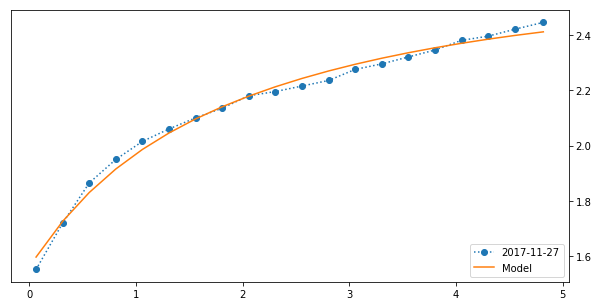

In [61]:
dt = '2017-11-27'
plot_futures(dt,settle,terms_new,rate_Q)

The updated parameters in TSM model is:

In [64]:
updated_paras=[m.r0 ,m.mu ,m.vol ,m.kappa]
print(updated_paras)

[-0.005355801273982326, -0.014852653801022481, 0.22530304362708176, 0.5938729543932019]


## The Model B: DNS

In [65]:
terms_new

array([0.0630137 , 0.31232877, 0.56164384, 0.8109589 , 1.06027397,
       1.30958904, 1.55890411, 1.80821918, 2.05753425, 2.30684932,
       2.55616438, 2.80547945, 3.05479452, 3.30410959, 3.55342466,
       3.80273973, 4.05205479, 4.30136986, 4.55068493, 4.81917808])

In [66]:
def betas(lamb,dfs):
    #set the parameters
    Betas=[]
    Resids=[]
    t=terms_new*12
    fac1=(1-np.e**(-lamb*t))/(lamb*t)
    fac2=fac1-np.e**(-lamb*t)
    #
    for i in range(len(dfs)):
        Y = dfs.iloc[i,:]
        X=np.concatenate(([fac1],[fac2]),axis=0).T
        X = sm.add_constant(X)
        model=sm.OLS(Y,X)
        result=model.fit()

        Resids.append(result.resid.tolist())
        Betas.append(result.params.tolist())
    return Betas,Resids

In [67]:
data=pd.DataFrame(100-settle.loc[dt,:])
dfs=data.T
lamb=0.5
Betas=betas(lamb,dfs)[0][0]
Betas

[2.4105861997922835, -0.7407670902377568, -1.489565847908164]

In [68]:
def rmses(lamb,dfs):
    _,resid=betas(lamb,dfs)
    Resids=np.array(resid)
    rmses=np.sqrt(np.sum((Resids**2)/Resids.shape[1],axis=1))
    #print(Resids.shape[1])
    return rmses

In [69]:
# Use bisection to find optimal lambda
ebs=0.0001
left=0.001
right=10
lamb=(left+right)/2

while abs(left-lamb)>0.001:

    resid_sum=sum(rmses(lamb,dfs))
    if resid_sum>sum(rmses(lamb+ebs,dfs)):
        left=lamb
    else:
        right=lamb
        
    lamb=(left+right)/2
    print('rmse reduces to {}'.format(resid_sum))
        
print("The optimal estimated lambda is: "+str(lamb))
Optimal_lambda=lamb

rmse reduces to 0.08359093662386664
rmse reduces to 0.08346899665591094
rmse reduces to 0.07974365150506835
rmse reduces to 0.06489264551530217
rmse reduces to 0.044899892958696376
rmse reduces to 0.030392546547712212
rmse reduces to 0.027165485427520397
rmse reduces to 0.027578246173269618
rmse reduces to 0.02692490654015115
rmse reduces to 0.02691127688577977
rmse reduces to 0.02688749830173185
rmse reduces to 0.026891382987209462
rmse reduces to 0.026887484400693072
The optimal estimated lambda is: 0.09315386962890623


In [70]:
lamb=Optimal_lambda
Betas=betas(lamb,dfs)[0][0]
Betas

[2.589667297999939, -1.0304438001074931, -4.815796994894761e-05]

In [71]:
t=terms_new*12
fac1=(1-np.e**(-lamb*t))/(lamb*t)
fac2=fac1-np.e**(-lamb*t)
X=np.concatenate(([fac1],[fac2]),axis=0).T
X = sm.add_constant(X)
y_model=X.dot(Betas)

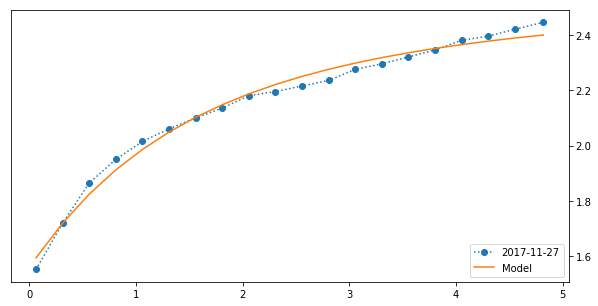

In [72]:
 def plot_futures(dt,frame,x,y):
    f = plt.figure(figsize=(10,5))
    ax = f.add_subplot(111)
    ax.yaxis.tick_right()  
    crv = frame.loc[dt]
    crv_rates = [100-z for z in crv.values]
    plots = [plt.plot(x,crv_rates,label=dt,linestyle="dotted",marker='o'),plt.plot(x,y,label='Model')]
    plt.legend(loc='lower right')    
    plt.show()
    
dt = '2017-11-27'
plot_futures(dt,settle,terms_new,y_model)

The updated parameters in TSM model is:

The optimal estimated lambda is: 0.0931 and the betas are [2.589667297999939, -1.0304438001074931, -4.815796994894761e-05] The model have a very nice fit to the term structure.

## Colinearity check

### TSM collinearity check with PCA

In the new optimization function, at each iteration there would be a PCA rank reduction process. To make approximate Hessian matrix more easy to be inverse, use PCA to reduce the collinearity every time in the Gaussian-Newtown optimization.

$$ P^{k+1}=P^{k}-H^{-1}g$$

But the Hessian matrix would be too expensive to calculate, so we use the following form to approach it.

The problem we see before is the collinearity, it is the same here with Jacobian matrix, we use PCA rank reduction to reduce the regression



$$P^{k+1}=P^{k}-(J_e.T*J)^-1 J_e*e$$


The code see below use the new function myfit() as the member function in the Fitter class:

In [81]:
from scipy.optimize import least_squares, leastsq

class Fitter:
    def __init__(self,model,fut_data,terms,dist):
        self.model = model
        self.data = np.array(fut_data)
        self.terms = terms
        self.dist = dist
    
    def residuals(self,x):
        m = self.model
        m.update_params(x)
        rate_dist = [m.mean_rate(t,t,t+0.25,self.dist)*100 for t in self.terms]
        return np.array(rate_dist) - self.data
    
    def fit(self,x0,solver='lm'):
        return least_squares(self.residuals,x0,method=solver)
        #return leastsq(self.residuals,x0)
        
        
    def myfit(self, x0, condition_value=100):
        
        tol=1e-11
        dt=1e-10 #diff for numerical Jacobian estimation
        max_iter=int(1e4)
        # the parameters initialization
        
        
        func=self.residuals
        resid = func(x0) # to measure output shape
        x0_dim = len(x0)
        jac_mat = np.zeros((len(resid), x0_dim))
        x1 = x0.copy() # only for starting point

        eig_val_s = None # to report collinearity

        while eig_val_s is None or (np.sum(np.abs(x1 - x0)) > tol and max_iter > 0):
            x0 = x1 # move forward

            resid = func(x0)

            # numerical Jacobian estimation
            for idx in range(x0_dim):
                this_x = x0.copy()

                this_x[idx] += dt
                jac_mat[:, idx] = func(this_x)
                this_x[idx] -= 2 * dt
                jac_mat[:, idx] -= func(this_x)
                jac_mat[:, idx] /= 2 * dt

            hessien_proxy = jac_mat.T @ jac_mat

            eig_val, eig_vec = np.linalg.eig(hessien_proxy)
            # notice that eig_val may not be sorted, do it manually 
            order = np.argsort(-eig_val) # from large to small
            eig_val = eig_val[order]
            eig_vec = eig_vec[:, order]

            # check collinearity
            last_idx = x0_dim - 1
            while (eig_val[0] / eig_val[last_idx]) > condition_value:
                last_idx -= 1

            eig_val_s = eig_val[:last_idx + 1]

            E0 = eig_vec[:, :last_idx + 1]
            hessien_proxy_inv = (E0 / eig_val[:last_idx+1]) @ E0.T 

            x1 = x0 - hessien_proxy_inv @ jac_mat.T @ resid

            max_iter -= 1

        return x1, eig_val_s

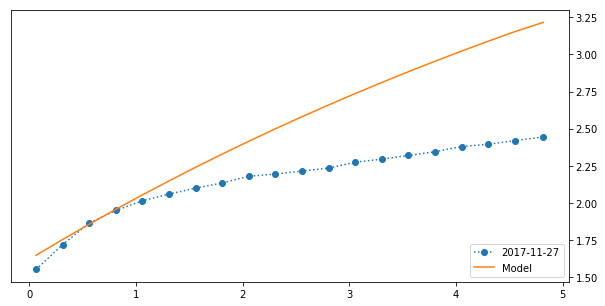

In [82]:
# The optimization of the parameters
#test Model class:
r0 = 0.015
mu = 0.005
vol = np.sqrt(0.008)
kappa=0.1
m = Model(r0,mu,vol,kappa)
#print (m.zero(0,1,r0))
x = range(1,21)
term = [xx/4. for xx in x]
rate_Q = [m.mean_rate(t,t,t+0.25,'Q')*100 for t in term]

plot_futures(dt,settle,terms_new,rate_Q)

### In the new optimization function, at each iteration there would be a PCA rank reduction process. To make approximate Hessian matrix more easy to be inverse, use PCA to reduce the collinearity every time in the Gaussian-Newtown optimization

In [83]:
f_fut = Fitter(m,crv_rates,terms_new,'Q')

best_para,jac_eigval = f_fut.myfit([0.005,0.015,0.008,0.1])

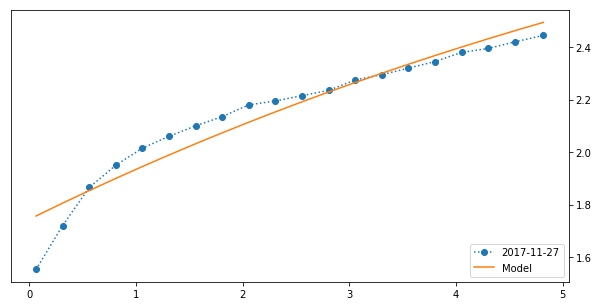

In [84]:
x = range(1,21)
#rate_F = [m.mean_rate(t,t,t+0.25,'F')*100 for t in term]
rate_Q = [m.mean_rate(t,t,t+0.25,'Q')*100 for t in terms_new]
crv_rates
plot_futures(dt,settle,terms_new,rate_Q)

In [85]:
updated_paras=[m.r0 ,m.mu ,m.vol ,m.kappa]
print(updated_paras)

[0.01713205661742883, 0.003916079767493065, 0.007981384338351027, 0.10332927963711117]


The parameters are updated as above. Since the PCA solved the matrix inverse problem, it surely lost some information inside, so the model fit is no longer as good looking as before. But the calculation for the newtown opitimization is for sure faster and stabler. It is a trade off between stablization and information integraty, which happens all the time.

### DNS Collinearity check with Ridge Regression

Search k from 0 (ordinary OLS) to 10; at each k, we grid search lambda from 0.01 to 10, to find a best fit of the Beta and the smallest residuals, then use the optimal lambda to generate the X in the DNS function

$$y=\beta_0+\beta1*X_1+\beta2*X_2$$

Then check if the condition value larger than a certain level, if CN larger than a threshold, we determine that collinearity exists. In that paper, they set CN as 10. First we use ordinary OLS (k=0), See the CN of the X from optimal lambda. and see if we get a good k, if not we carry on untill we got one.

In [113]:
k=0
from sklearn.linear_model import Ridge
for lamd in np.arange(0.01,10,100):

    fac1=(1-np.e**(-lamb*t))/(lamb*t)
    fac2=fac1-np.e**(-lamb*t)
    X=np.concatenate(([fac1],[fac2]),axis=0).T
    #X = sm.add_constant(X)
    y=dfs.values.T

    clf = Ridge(alpha=k)
    clf.fit(X, y) 

    resid=sum((y-clf.predict(X)).reshape(-1))

    if resid<min_resid:
        min_resid=resid
        opt_lamb=lamb

lamb=opt_lamb
t=terms_new*12
fac1=(1-np.e**(-lamb*t))/(lamb*t)
fac2=fac1-np.e**(-lamb*t)
X=np.concatenate(([fac1],[fac2]),axis=0).T

X_cov=np.cov(X.T)
eigval,eigvec=np.linalg.eig(X_cov)

CN_0=max(eigval)/min(eigval)

print("The CN from the best lambda when k=0 are",CN_0)

The CN from the best lambda when k=0 are 15.350240103159786


CN seems small enough, the value is 15.35, then we want to make sure it is for sure no colinearity problem:

Then we iterate from k=0 to k=50, step by 0.01, overall 50000 times iteration only for k:

In [114]:
from sklearn.linear_model import Ridge
min_resid=np.inf # initialize a minimum residuals
condition_v=CN_0+1 # initialize a conditional value
largecount=5e+4 # large 
t=terms_new*12
k=0 # Start here when it is a OLS problem
# for k in np.linspace(0,0.05,6):
while condition_v>CN_0 and largecount>0:
    
    
    for lamd in np.arange(0.01,10,100):


        fac1=(1-np.e**(-lamb*t))/(lamb*t)
        fac2=fac1-np.e**(-lamb*t)
        X=np.concatenate(([fac1],[fac2]),axis=0).T
        #X = sm.add_constant(X)
        y=dfs.values.T

        clf = Ridge(alpha=k,fit_intercept=False)
        clf.fit(X, y) 

        resid=sum((y-clf.predict(X)).reshape(-1))

        if resid<min_resid:
            min_resid=resid
            opt_lamb=lamb

    lamb=opt_lamb
    fac1=(1-np.e**(-lamb*t))/(lamb*t)
    fac2=fac1-np.e**(-lamb*t)
    X=np.concatenate(([fac1],[fac2]),axis=0).T
    
    X_cov=np.cov(X.T)
    eigval,eigvec=np.linalg.eig(X_cov)

    condition_v=max(eigval)/min(eigval)
        #print(condition_v)
    largecount-=1
    k+=0.001

print('The parameters are:', largecount,opt_lamb,k,condition_v)


The parameters are: 49999.0 0.09315386962890623 0.001 15.350240103159786


After 50000 iteration from k=0 to k=10, there is no decrease in CN, we could safely conclude that there should be no collinearity problem under Ridge Regression check.

So the graph is the same with the OLS DNS problem we did before:

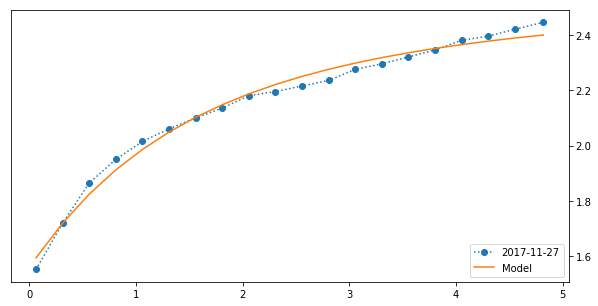

In [116]:
dt = '2017-11-27'
plot_futures(dt,settle,terms_new,y_model)

## Explain my work:

### For TSM:

In the new optimization function, at each iteration there would be a PCA rank reduction process. To make approximate Hessian matrix more easy to be inverse, use PCA to reduce the collinearity every time in the Gaussian-Newtown optimization.

$$ P^{k+1}=P^{k}-H^{-1}g$$

But the Hessian matrix would be too expensive to calculate, so we use the following form to approach it.

The problem we see before is the collinearity, it is the same here with Jacobian matrix, we use PCA rank reduction to reduce the regression



$$P^{k+1}=P^{k}-(J_e.T*J)^-1 J_e*e$$


The parameters are updated as above. Since the PCA solved the matrix inverse problem, it surely lost some information inside, so the model fit is no longer as good looking as before. But the calculation for the newtown opitimization is for sure faster and stabler. It is a trade off between stablization and information integraty, which happens all the time.


### For DNS:

Search k from 0 (ordinary OLS) to 10; at each k, we grid search lambda from 0.01 to 10, to find a best fit of the Beta and the smallest residuals, then use the optimal lambda to generate the X in the DNS function

$$y=\beta_0+\beta1*X_1+\beta2*X_2$$

Then check if the condition value $$CN=\frac{max(EigenValue(Cov(X))}{min(EigenValue(Cov(X))}$$ defined by [Jan Annaert. 2012],

If CN larger than a threshold, we determine that collinearity exists. In that paper, they set CN as 10.

First we use ordinary OLS (k=0), See the CN of the X from optimal lambda.


The CN of this is very close to the threshold (10) in the paper we mentioned before, to make sure if there is absolutely no collinearity problem, I still need to search from k=0 to k=10. If there is decrease in CN with increasing the panelty k in Ridge Regression, we could conclude that there is still collinearity problem and we should use Ridge Regression, if there is no decrease in CN, we say it is not necessary to use panelty k hence there is no colinearity in this problem.